In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from fama_french import load_annual_factors, ff_display


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Fama French Factors

Downloaded Fama-French model from [French's website](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Developed) around June 16, 2019:

- [Details](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_factors.html)
- [File](http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip)

The file gives monthly returns initially and annual returns at the end.

In [2]:
df_factors = load_annual_factors()
df_factors.head()

,Year,Mkt-RF,SMB,HML,RF,Alpha
0,1927,0.2947,-0.0246,-0.0375,0.0312,1.0
1,1928,0.3539,0.0420,-0.0615,0.0356,1.0
2,1929,-0.1954,-0.3080,0.1181,0.0475,1.0
3,1930,-0.3123,-0.0513,-0.1228,0.0241,1.0
4,1931,-0.4511,0.0353,-0.1429,0.0107,1.0


# Load Tactical America Smart Weight Index

In [3]:
def to_percent(ser):
    return (ser.str.rstrip('%')
        .astype(float)
        .pipe(lambda x: x/100.))

In [4]:
df_russell = pd.read_csv("data/Russell.tsv", sep='\t').rename({'Unnamed: 0': "Year"}, axis=1)
    
df_russell[['Smart Weighting', 'S&P 500']] = df_russell[['Smart Weighting', 'S&P 500']].apply(to_percent)
    
df_russell.head()

,Year,Smart Weighting,S&P 500
0,1991,0.335,0.306
1,1992,0.118,0.077
2,1993,0.133,0.100
3,1994,0.022,0.013
4,1995,0.368,0.374


In [5]:
df1 = df_russell.merge(df_factors, on='Year', how='inner')
df1.head()

,Year,Smart Weighting,S&P 500,Mkt-RF,SMB,HML,RF,Alpha
0,1991,0.335,0.306,0.2918,0.1613,-0.1441,0.0560,1.0
1,1992,0.118,0.077,0.0623,0.0758,0.2428,0.0351,1.0
2,1993,0.133,0.100,0.0821,0.0580,0.1890,0.0290,1.0
3,1994,0.022,0.013,-0.0410,-0.0107,-0.0066,0.0390,1.0
4,1995,0.368,0.374,0.3122,-0.0910,0.0524,0.0560,1.0


# Excess Return of Smart Weighting

In [6]:
(df1['Smart Weighting'] - df1['S&P 500']).mean()

0.013666666666666674

# Fama French Factors

,Smart Weighting,S&P 500
Mkt-RF,0.954591,0.990379
SMB,0.052521,-0.159506
HML,0.156031,0.041177
Alpha,0.005723,-0.000011
R^2,0.982191,0.997312


,Smart Weighting,S&P 500
Mkt-RF,0.073213,0.075957
SMB,0.001533,-0.004655
HML,0.006098,0.001609
Alpha,0.005723,-0.000011


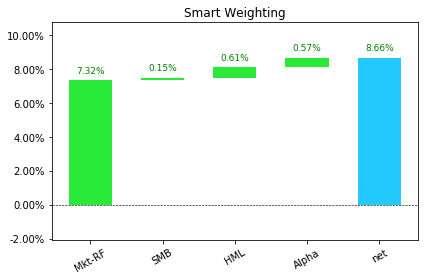

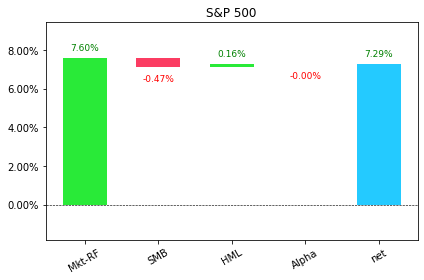

In [7]:
ff_display(df1, ('Smart Weighting', 'S&P 500'))

# Load Personal Capital Returns

These were downloaded June 16th, 2019 from the [Personal Capital Website](https://www.personalcapital.com/wealth-management/performance)

In [8]:
with open('data/Personal_Capital_Performancel.html') as fh:
    html = fh.read()
    html = html.replace('colspan="100%"', '')  # manually remove poorly formatted HTML
    df_pc_raw = pd.read_html(html)[0]
    
df_pc_raw.head()

,Types,2012,2013,2014,2015,2016,2017,2018,YTD (through 3/31),Since Inception (Annualized)
0,Aggressive 1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Composite Personal Strategy,18.3%,22.1%,3.9%,-1.5%,10.8%,17.9%,-8.3%,12.0%,11.0%
2,Comparative Benchmark,15.1%,20.4%,4.9%,-3.2%,9.3%,19.9%,-8.3%,11.8%,10.1%
3,Growth 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Composite Personal Strategy,16.9%,18.0%,3.2%,-2.0%,10.2%,16.3%,-7.5%,10.9%,9.7%


In [9]:
df_pc = pd.DataFrame(
    df_pc_raw.loc[
        [1, 4, 7, 10, 13, 16, 18],
        '2012':'2018'
    ].values,
    index=df_pc_raw.iloc[[0, 3, 6, 9, 12, 15, 18]]['Types'].values,
    columns=range(2012, 2019)
).T

df_pc = df_pc.apply(to_percent)
df_pc.to_csv("data/pc_annual_returns.csv")
df_pc.head()

,Aggressive 1,Growth 2,Moderate 3,Balanced 4,Conservative 5,Tactical America 6,S&P 500 Proxy ETF (SPY)
2012,0.183,0.169,0.155,0.135,0.113,0.178,0.160
2013,0.221,0.180,0.140,0.102,0.074,0.340,0.323
2014,0.039,0.032,0.026,0.022,0.020,0.071,0.135
2015,-0.015,-0.020,-0.025,-0.027,-0.029,0.018,0.012
2016,0.108,0.102,0.096,0.085,0.077,0.141,0.120


In [10]:
df2 = df_pc.merge(df_factors, left_index=True, right_on='Year', how='inner')
df2.head()

,Aggressive 1,Growth 2,Moderate 3,Balanced 4,Conservative 5,Tactical America 6,S&P 500 Proxy ETF (SPY),Year,Mkt-RF,SMB,HML,RF,Alpha
85,0.183,0.169,0.155,0.135,0.113,0.178,0.160,2012,0.1628,-0.0115,0.0973,0.0006,1.0
86,0.221,0.180,0.140,0.102,0.074,0.340,0.323,2013,0.3520,0.0727,0.0150,0.0002,1.0
87,0.039,0.032,0.026,0.022,0.020,0.071,0.135,2014,0.1170,-0.0808,-0.0164,0.0002,1.0
88,-0.015,-0.020,-0.025,-0.027,-0.029,0.018,0.012,2015,0.0007,-0.0405,-0.0961,0.0002,1.0
89,0.108,0.102,0.096,0.085,0.077,0.141,0.120,2016,0.1330,0.0660,0.2289,0.0020,1.0


In [11]:
(df2['Tactical America 6'] - df2['S&P 500 Proxy ETF (SPY)']).mean()

-0.00985714285714285

,Smart Weighting,S&P 500
Mkt-RF,0.954591,0.990379
SMB,0.052521,-0.159506
HML,0.156031,0.041177
Alpha,0.005723,-0.000011
R^2,0.982191,0.997312


,Smart Weighting,S&P 500
Mkt-RF,0.073213,0.075957
SMB,0.001533,-0.004655
HML,0.006098,0.001609
Alpha,0.005723,-0.000011


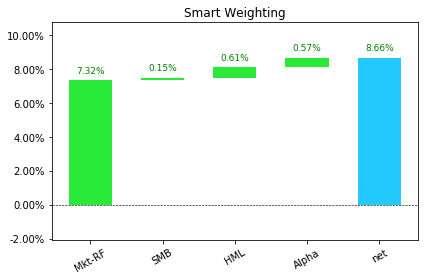

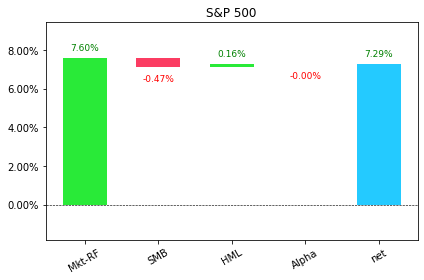

In [12]:
ff_display(df1, ('Smart Weighting', 'S&P 500'))

,Aggressive 1,Growth 2,Moderate 3,Balanced 4,Conservative 5,Tactical America 6,S&P 500 Proxy ETF (SPY)
Mkt-RF,0.818227,0.722536,0.622154,0.512395,0.428431,0.856183,0.959264
SMB,-0.290543,-0.361265,-0.425961,-0.462183,-0.470702,0.325036,-0.243706
HML,0.191388,0.225015,0.265015,0.280020,0.280439,0.048059,0.031822
Alpha,-0.023416,-0.023270,-0.022874,-0.021538,-0.020985,0.009587,-0.000077
R^2,0.909541,0.883281,0.853685,0.828094,0.816537,0.978553,0.999263


,Aggressive 1,Growth 2,Moderate 3,Balanced 4,Conservative 5,Tactical America 6,S&P 500 Proxy ETF (SPY)
Mkt-RF,0.106510,0.094054,0.080987,0.066699,0.055769,0.111451,0.124869
SMB,0.003113,0.003871,0.004564,0.004952,0.005043,-0.003483,0.002611
HML,-0.000107,-0.000125,-0.000148,-0.000156,-0.000156,-0.000027,-0.000018
Alpha,-0.023416,-0.023270,-0.022874,-0.021538,-0.020985,0.009587,-0.000077


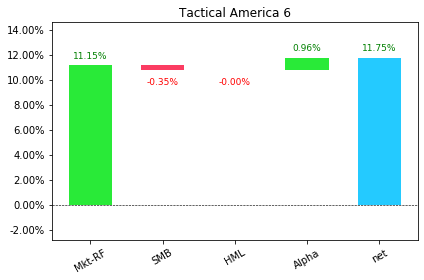

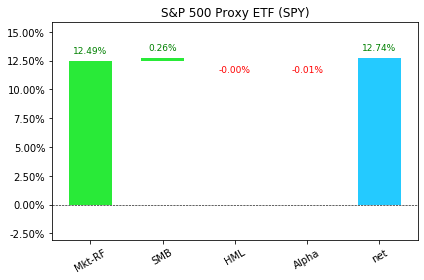

In [13]:
INDEX_COLS = (
    'Aggressive 1',
    'Growth 2',
    'Moderate 3',
    'Balanced 4',
    'Conservative 5',
    'Tactical America 6',
    'S&P 500 Proxy ETF (SPY)',
)

WATERFALL_COLS = (
    'Tactical America 6',
    'S&P 500 Proxy ETF (SPY)',
)

ff_display(df2, INDEX_COLS, WATERFALL_COLS)